In [84]:
import os
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import nilearn.plotting as niplot
from nilearn.masking import apply_mask
from scipy.ndimage import center_of_mass
from nilearn.image import mean_img
from scipy.ndimage import label
import pandas as pd

In [85]:
os.chdir('/home/gusia/Desktop/BrainHack/brainhack_env/example_data/')

In [86]:
def calculate_center_of_mass(voxel_data):
    """Compute the center of mass for a 3D voxel array."""
    # Create grid indices (voxel coordinates)
    z, y, x = np.indices(voxel_data.shape)
    
    # Total intensity (sum of all voxel values)
    total_intensity = np.sum(voxel_data)
    
    # Compute weighted average for each axis
    com_x = np.sum(x * voxel_data) / total_intensity
    com_y = np.sum(y * voxel_data) / total_intensity
    com_z = np.sum(z * voxel_data) / total_intensity
    
    return (com_x, com_y, com_z)

In [87]:
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
mask_img = nib.load("BrainHack_ocular_fMRI/graymattermask_resampled.nii.gz")
eyemask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")

# Extract data from one time point (e.g., the first volume)
fmri_data_4d = fmri_img.get_fdata()
fmri_volume = fmri_data_4d[..., 0]  # Choose volume 0 (can be any time index)

# Load and binarize the brain mask
mask_data = mask_img.get_fdata().astype(bool)
eyemask_data = eyemask_img.get_fdata().astype(bool)

# Apply mask to fMRI
brain_only = fmri_volume * mask_data
eyes_only = fmri_volume * eyemask_data

# # Compute center of mass from the mask
# com = center_of_mass(mask_data)
# x_c, y_c, z_c = map(int, com)
# print(f"Brain Center of Mass: x={x_c}, y={y_c}, z={z_c}")

# Distinguishing the eyes
without_gm = eyes_only - brain_only

# Compute Center of Mass
com_x, com_y, com_z = calculate_center_of_mass(without_gm)
print(f"Center of Mass (x, y, z): ({com_x:.2f}, {com_y:.2f}, {com_z:.2f})")


Center of Mass (x, y, z): (22.81, 27.09, 23.85)


In [114]:
n_timepoints = fmri_img.shape[3]
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
mask_img = nib.load("BrainHack_ocular_fMRI/graymattermask_resampled.nii.gz")
eyemask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")
fmri_data_4d = fmri_img.get_fdata()  # Must come before getting shape

n_timepoints = fmri_data_4d.shape[3]

left_eye_time = np.empty(n_timepoints, dtype='object')
right_eye_time = np.empty(n_timepoints, dtype='object')

left_center = np.zeros((n_timepoints, 3), dtype=float)
right_center = np.zeros((n_timepoints, 3), dtype=float)

left_center_bright = np.zeros((n_timepoints, 3), dtype=float)
right_center_bright = np.zeros((n_timepoints, 3), dtype=float)

for t in range(n_timepoints):
    
    # Extract data from one time point (e.g., the first volume)
    fmri_data_4d = fmri_img.get_fdata()
    fmri_volume = fmri_data_4d[..., t]  # Choose volume 0 (can be any time index)
    
    # Load and binarize the brain mask
    mask_data = mask_img.get_fdata().astype(bool)
    eyemask_data = eyemask_img.get_fdata().astype(bool)
    
    # Apply mask to fMRI
    brain_only = fmri_volume * mask_data
    eyes_only = fmri_volume * eyemask_data
    
    # Compute center of mass from the mask
    # com = center_of_mass(mask_data)
    # x_c, y_c, z_c = map(int, com)
    # print(f"Brain Center of Mass: x={x_c}, y={y_c}, z={z_c}")
    
    # Distinguishing the eyes
    without_gm = eyes_only - brain_only

    without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)

    #brain_only_img = nib.Nifti1Image(brain_only, affine=fmri_img.affine)

    #fmri_volume_img = nib.Nifti1Image(fmri_volume, affine=fmri_img.affine)

    #eyes_img = nib.Nifti1Image(eyes, affine=fmri_img.affine)

        # # Define Y-axis bounds
    # y_start = 100
    # z_start = -70
    # y_end = y_start - 59  # So y = 100 down to y = 40 (smaller values)
    # z_end = z_start + 37
    
    # # Mask the region of interest
    # eyes_roi = np.zeros_like(eyes)
    eyes_roi = without_gm
    # #eyes_roi[:, y_end:y_start, :] = eyes[:, y_end:y_start, :]
    # eyes_roi[:, y_end:y_start, z_start:z_end] = eyes[:, y_end:y_start, z_start:z_end]
    
    # Flatten the ROI and keep only non-zero values
    flat_eyes_roi = eyes_roi.ravel()
    nonzero_indices = np.flatnonzero(flat_eyes_roi)
    n_nonzero = len(nonzero_indices)
    top_n = int(n_nonzero * 0.01)
    
    print(f"Total non-zero voxels in ROI: {n_nonzero}")
    print(f"Extracting top {top_n} voxels (top 1%)")
    
    # Get top 100 brightest voxel indices within the ROI
    flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
    sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
    brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
    
    #flat_indices = np.argpartition(eyes_roi.ravel(), -300)[-300:]
    #sorted_flat_indices = flat_indices[np.argsort(eyes_roi.ravel()[flat_indices])[::-1]]
    #brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
    
    # Create empty image to store the brightest voxels
    brightest_voxels_img = np.zeros_like(eyes_roi)
    
    # Set the intensity values at those coordinates
    for x, y, z in brightest_coords:
        brightest_voxels_img[x, y, z] = eyes_roi[x, y, z]  # You can also use eyes_roi here; same in that range
    
    # Wrap into Nifti1Image using original affine
    brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
    # nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")
    
    # Plot interactively
    # plotting.view_img(brightest_voxels_nii, threshold=0) # opacity=0.5

    # Label connected components (regions of adjacent bright voxels)
    labeled, num_labels = label(brightest_voxels_img)
    
    # Find the size of each connected component (cluster)
    component_sizes = np.bincount(labeled.ravel())
    
    # Ignore background (label 0), sort the components by size and find the largest and second largest components
    sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)
    
    # Ignore background (label 0) and find the largest component
    largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
    largest_component = labeled == largest_component_label
    
    second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
    # Create an image of the largest component
    largest_component_img = np.zeros_like(fmri_volume)
    largest_component_img[largest_component] = fmri_volume[largest_component]
    
    # Create the second largest component (second biggest cluster)
    second_largest_component = labeled == second_largest_label
    
    # Create an image of the second largest component
    second_largest_img = np.zeros_like(fmri_volume)
    second_largest_img[second_largest_component] = fmri_volume[second_largest_component]
    
    # Wrap into a NIfTI image
    second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)
    
    # Wrap into a NIfTI image
    largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)
    
    # Create an image for both clusters combined (sum of both masks)
    combined_clusters_img = np.zeros_like(fmri_volume)
    combined_clusters_img[largest_component] = fmri_volume[largest_component]
    combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]
    
    # Wrap into a NIfTI image
    combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)
    
    # Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
    largest_coords = np.column_stack(np.where(largest_component))
    second_largest_coords = np.column_stack(np.where(second_largest_component))
    
    largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
    second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]
    
    if largest_coords_world[0][0] < 0:
        left_eye_img = largest_component_nii
        right_eye_img = second_largest_nii
    else:
        left_eye_img = second_largest_nii
        right_eye_img = largest_component_nii

    left_data = left_eye_img.get_fdata()
    right_data = right_eye_img.get_fdata()
    
    # Find brightest voxel index (max intensity)
    left_max_idx = np.unravel_index(np.argmax(left_data), left_data.shape)
    right_max_idx = np.unravel_index(np.argmax(right_data), right_data.shape)

    com_xl, com_yl, com_zl = calculate_center_of_mass(left_data)
    com_xr, com_yr, com_zr = calculate_center_of_mass(right_data)

    #print(f"Center of Mass (x, y, z): ({com_x:.2f}, {com_y:.2f}, {com_z:.2f})")
    left_center[t] = [com_xl, com_yl, com_zl]
    right_center[t] = [com_xr, com_yr, com_zr]

    #Store voxel-space coordinates - brightness
    x_l, y_l, z_l = left_max_idx
    x_r, y_r, z_r = right_max_idx
    
    left_center_bright[t] = [x_l, y_l, z_l]
    right_center_bright[t] = [x_r, y_r, z_r]
    
    left_eye_time[t] = left_eye_img
    right_eye_time[t] = right_eye_img

    # left_eye_img_bool = left_eye_img.get_fdata().astype(bool)
    # right_eye_img_bool = right_eye_img.get_fdata().astype(bool)

    # com_left = center_of_mass(left_eye_img_bool)
    # x_l, y_l, z_l = map(int, com_left)

    # com_right = center_of_mass(right_eye_img_bool)
    # x_r, y_r, z_r = map(int, com_right)
    
# Save the combined clusters result
# nib.save(combined_clusters_nii, "combined_clusters_brightest_voxels.nii.gz")

# # Save the largest component
# nib.save(left_eye_img, "left_eye_both_masks.nii.gz")

# # Save the second largest component
# nib.save(right_eye_img, "right_eye_both_masks.nii.gz")

# Plot interactively both clusters together (overlaying)
# plotting.view_img(left_eye_img, threshold=0)

Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31484
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31481
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31479
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31480
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31484
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31480
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31485
Extracting top 314 voxels (top 1%)
Total 

In [117]:
# Create DataFrame - CSV file - CENTRE OF MASS

df_centers = pd.DataFrame({
    'timepoint': np.arange(len(left_center)),
    'x_left_voxel': left_center[:, 0],
    'y_left_voxel': left_center[:, 1],
    'z_left_voxel': left_center[:, 2],
    'x_right_voxel': right_center[:, 0],
    'y_right_voxel': right_center[:, 1],
    'z_right_voxel': right_center[:, 2],
})

# Save to CSV
df_centers.to_csv("centre_of_mass_corrected_eye_voxels.csv", index=False)

print("Saved to centre_of_mass_corrected_eye_voxels.csv")

Saved to centre_of_mass_corrected_eye_voxels.csv


In [118]:
# Create DataFrame - CSV file - BRIGHTNESS

df_centers_brightness = pd.DataFrame({
    'timepoint': np.arange(len(left_center_bright)),
    'x_left_voxel': left_center_bright[:, 0],
    'y_left_voxel': left_center_bright[:, 1],
    'z_left_voxel': left_center_bright[:, 2],
    'x_right_voxel': right_center_bright[:, 0],
    'y_right_voxel': right_center_bright[:, 1],
    'z_right_voxel': right_center_bright[:, 2],
})

# Save to CSV
df_centers.to_csv("brightness_corrected_eye_voxels.csv", index=False)

print("Saved to brightness_corrected_eye_voxels.csv")

Saved to brightness_corrected_eye_voxels.csv


In [121]:
from scipy.stats import zscore

# Select only coordinate columns
coord_cols = [
    'x_left_voxel', 'y_left_voxel', 'z_left_voxel',
    'x_right_voxel', 'y_right_voxel', 'z_right_voxel'
]

# Compute Z-scores for each coordinate
z_scores = np.abs(zscore(df_centers[coord_cols]))

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Keep only rows where ALL z-scores are below the threshold
mask = (z_scores < threshold).all(axis=1)

# Apply mask
df_cleaned = df_centers[mask].reset_index(drop=True)

print(f"Removed {len(df_centers) - len(df_cleaned)} outliers")

Removed 7 outliers


In [125]:
from scipy.stats import zscore

# Select only coordinate columns
coord_cols = [
    'x_left_voxel', 'y_left_voxel', 'z_left_voxel',
    'x_right_voxel', 'y_right_voxel', 'z_right_voxel'
]

# Compute Z-scores for each coordinate
z_scores = np.abs(zscore(df_centers_brightness[coord_cols]))

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Keep only rows where ALL z-scores are below the threshold
mask = z_scores.mean(axis=1) < threshold

# Apply mask
df_cleaned_brightness = df_centers_brightness[mask].reset_index(drop=True)

print(f"Removed {len(df_centers_brightness) - len(df_cleaned_brightness)} outliers")

Removed 1 outliers


In [134]:
df = pd.read_csv("brightness_corrected_eye_voxels.csv")

In [145]:
df = pd.read_csv("centre_of_mass_corrected_eye_voxels.csv")

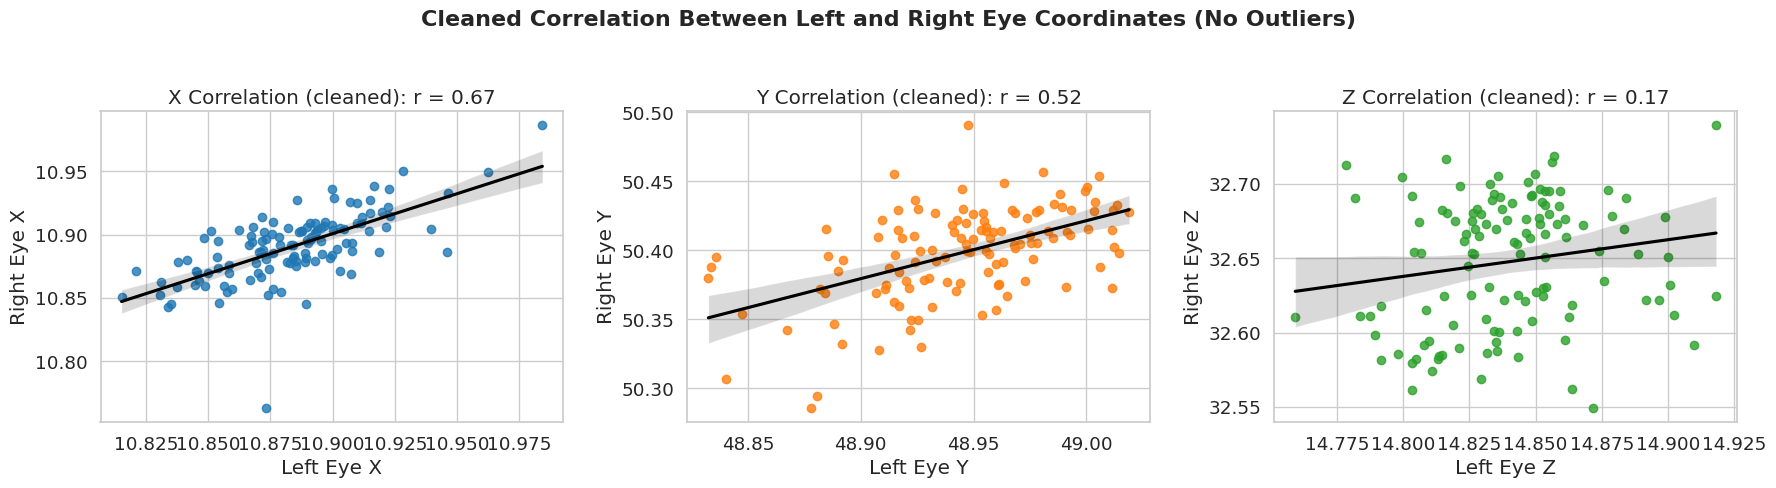

In [146]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(data=df_cleaned, x='x_left_voxel', y='x_right_voxel', ax=axs[0], color='#1f77b4', line_kws={'color': 'black'})
axs[0].set_title(f"X Correlation (cleaned): r = {cor_x:.2f}")
axs[0].set_xlabel("Left Eye X")
axs[0].set_ylabel("Right Eye X")

sns.regplot(data=df_cleaned, x='y_left_voxel', y='y_right_voxel', ax=axs[1], color='#ff7f0e', line_kws={'color': 'black'})
axs[1].set_title(f"Y Correlation (cleaned): r = {cor_y:.2f}")
axs[1].set_xlabel("Left Eye Y")
axs[1].set_ylabel("Right Eye Y")

sns.regplot(data=df_cleaned, x='z_left_voxel', y='z_right_voxel', ax=axs[2], color='#2ca02c', line_kws={'color': 'black'})
axs[2].set_title(f"Z Correlation (cleaned): r = {cor_z:.2f}")
axs[2].set_xlabel("Left Eye Z")
axs[2].set_ylabel("Right Eye Z")

plt.savefig("COM_eye_voxel_correlation_outliers_removed_plot.png")

plt.suptitle("Cleaned Correlation Between Left and Right Eye Coordinates (No Outliers)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [141]:
plt.savefig("BRIGHT_eye_voxel_correlation_outliers_removed_plot.png")

<Figure size 640x480 with 0 Axes>

In [35]:
n_timepoints = fmri_img.shape[3]
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
mask_img = nib.load("BrainHack_ocular_fMRI/graymattermask_resampled.nii.gz")
eyemask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")
fmri_data_4d = fmri_img.get_fdata()  # Must come before getting shape

n_timepoints = fmri_data_4d.shape[3]

left_eye_time = np.empty(n_timepoints, dtype='object')
right_eye_time = np.empty(n_timepoints, dtype='object')

left_center = np.zeros((n_timepoints, 3), dtype=int)
right_center = np.zeros((n_timepoints, 3), dtype=int)

for t in range(n_timepoints):
    
    # Extract data from one time point (e.g., the first volume)
    fmri_data_4d = fmri_img.get_fdata()
    fmri_volume = fmri_data_4d[..., t]  # Choose volume 0 (can be any time index)
    
    # Load and binarize the brain mask
    mask_data = mask_img.get_fdata().astype(bool)
    eyemask_data = eyemask_img.get_fdata().astype(bool)
    
    # Apply mask to fMRI
    brain_only = fmri_volume * mask_data
    eyes_only = fmri_volume * eyemask_data
    
    # Compute center of mass from the mask
    # com = center_of_mass(mask_data)
    # x_c, y_c, z_c = map(int, com)
    # print(f"Brain Center of Mass: x={x_c}, y={y_c}, z={z_c}")
    
    # Distinguishing the eyes
    without_gm = eyes_only - brain_only

    without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)

    #brain_only_img = nib.Nifti1Image(brain_only, affine=fmri_img.affine)

    #fmri_volume_img = nib.Nifti1Image(fmri_volume, affine=fmri_img.affine)

    #eyes_img = nib.Nifti1Image(eyes, affine=fmri_img.affine)

        # # Define Y-axis bounds
    # y_start = 100
    # z_start = -70
    # y_end = y_start - 59  # So y = 100 down to y = 40 (smaller values)
    # z_end = z_start + 37
    
    # # Mask the region of interest
    # eyes_roi = np.zeros_like(eyes)
    eyes_roi = without_gm
    # #eyes_roi[:, y_end:y_start, :] = eyes[:, y_end:y_start, :]
    # eyes_roi[:, y_end:y_start, z_start:z_end] = eyes[:, y_end:y_start, z_start:z_end]
    
    # Flatten the ROI and keep only non-zero values
    flat_eyes_roi = eyes_roi.ravel()
    nonzero_indices = np.flatnonzero(flat_eyes_roi)
    n_nonzero = len(nonzero_indices)
    top_n = int(n_nonzero * 0.01)
    
    print(f"Total non-zero voxels in ROI: {n_nonzero}")
    print(f"Extracting top {top_n} voxels (top 1%)")
    
    # Get top 100 brightest voxel indices within the ROI
    flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
    sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
    brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
    
    #flat_indices = np.argpartition(eyes_roi.ravel(), -300)[-300:]
    #sorted_flat_indices = flat_indices[np.argsort(eyes_roi.ravel()[flat_indices])[::-1]]
    #brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
    
    # Create empty image to store the brightest voxels
    brightest_voxels_img = np.zeros_like(eyes_roi)
    
    # Set the intensity values at those coordinates
    for x, y, z in brightest_coords:
        brightest_voxels_img[x, y, z] = eyes_roi[x, y, z]  # You can also use eyes_roi here; same in that range
    
    # Wrap into Nifti1Image using original affine
    brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
    # nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")
    
    # Plot interactively
    # plotting.view_img(brightest_voxels_nii, threshold=0) # opacity=0.5

    # Label connected components (regions of adjacent bright voxels)
    labeled, num_labels = label(brightest_voxels_img)
    
    # Find the size of each connected component (cluster)
    component_sizes = np.bincount(labeled.ravel())
    
    # Ignore background (label 0), sort the components by size and find the largest and second largest components
    sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)
    
    # Ignore background (label 0) and find the largest component
    largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
    largest_component = labeled == largest_component_label
    
    second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
    # Create an image of the largest component
    largest_component_img = np.zeros_like(fmri_volume)
    largest_component_img[largest_component] = fmri_volume[largest_component]
    
    # Create the second largest component (second biggest cluster)
    second_largest_component = labeled == second_largest_label
    
    # Create an image of the second largest component
    second_largest_img = np.zeros_like(fmri_volume)
    second_largest_img[second_largest_component] = fmri_volume[second_largest_component]
    
    # Wrap into a NIfTI image
    second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)
    
    # Wrap into a NIfTI image
    largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)
    
    # Create an image for both clusters combined (sum of both masks)
    combined_clusters_img = np.zeros_like(fmri_volume)
    combined_clusters_img[largest_component] = fmri_volume[largest_component]
    combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]
    
    # Wrap into a NIfTI image
    combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)
    
    # Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
    largest_coords = np.column_stack(np.where(largest_component))
    second_largest_coords = np.column_stack(np.where(second_largest_component))
    
    largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
    second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]
    
    if largest_coords_world[0][0] < 0:
        left_eye_img = largest_component_nii
        right_eye_img = second_largest_nii
    else:
        left_eye_img = second_largest_nii
        right_eye_img = largest_component_nii

    left_data = left_eye_img.get_fdata()
    right_data = right_eye_img.get_fdata()
    
    # Find brightest voxel index (max intensity)
    left_max_idx = np.unravel_index(np.argmax(left_data), left_data.shape)
    right_max_idx = np.unravel_index(np.argmax(right_data), right_data.shape)
    
    # Store voxel-space coordinates
    x_l, y_l, z_l = left_max_idx
    x_r, y_r, z_r = right_max_idx
    
    left_center[t] = [x_l, y_l, z_l]
    right_center[t] = [x_r, y_r, z_r]
            
    # left_eye_time[t] = left_eye_img
    # right_eye_time[t] = right_eye_img

    # left_eye_img_bool = left_eye_img.get_fdata().astype(bool)
    # right_eye_img_bool = right_eye_img.get_fdata().astype(bool)

    # com_left = center_of_mass(left_eye_img_bool)
    # x_l, y_l, z_l = map(int, com_left)

    # com_right = center_of_mass(right_eye_img_bool)
    # x_r, y_r, z_r = map(int, com_right)
    
    # left_center[t] = [x_l, y_l, z_l]
    # right_center[t] = [x_r, y_r, z_r]
    
# Save the combined clusters result
# nib.save(combined_clusters_nii, "combined_clusters_brightest_voxels.nii.gz")

# # Save the largest component
# nib.save(left_eye_img, "left_eye_both_masks.nii.gz")

# # Save the second largest component
# nib.save(right_eye_img, "right_eye_both_masks.nii.gz")

# Plot interactively both clusters together (overlaying)
# plotting.view_img(left_eye_img, threshold=0)

Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31484
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31481
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31479
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31480
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31484
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31480
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31483
Extracting top 314 voxels (top 1%)
Total non-zero voxels in ROI: 31485
Extracting top 314 voxels (top 1%)
Total 

In [24]:
# Save the result
# Convert each time point's image to a 3D NumPy array
left_data = np.stack([img.get_fdata() for img in left_eye_time], axis=-1)  # shape: (X, Y, Z, T)
right_data = np.stack([img.get_fdata() for img in right_eye_time], axis=-1)

# Use the affine from the first time point
affine = left_eye_time[0].affine

# Create and save 4D NIfTI
left_4d_img = nib.Nifti1Image(left_data, affine)
right_4d_img = nib.Nifti1Image(right_data, affine)

nib.save(left_4d_img, "left_eye_time.nii.gz")
nib.save(right_4d_img, "right_eye_time.nii.gz")

In [26]:
# Save the results - Python
np.save("left_eye_centers.npy", left_center)
np.save("right_eye_centers.npy", right_center)

In [36]:
# Create DataFrame - CSV file
df_centers = pd.DataFrame({
    'timepoint': np.arange(len(left_center)),
    'x_left_voxel': left_center[:, 0],
    'y_left_voxel': left_center[:, 1],
    'z_left_voxel': left_center[:, 2],
    'x_right_voxel': right_center[:, 0],
    'y_right_voxel': right_center[:, 1],
    'z_right_voxel': right_center[:, 2],
})

# Save to CSV
df_centers.to_csv("brightest_eye_voxels.csv", index=False)

print("Saved to brightest_eye_voxels.csv")

Saved to brightest_eye_voxels.csv


In [ ]:
# MULTI VOXEL PATTERN ANALYSIS
# compare brightness of voxels in all time points
# run a correlation between subsequent slices

In [80]:
# Difference between time points for each coordinate
left_deltas = np.diff(left_center, axis=0)     # shape: (T-1, 3)
right_deltas = np.diff(right_center, axis=0)   # shape: (T-1, 3)

# You can also compute the overall distance moved at each step
left_movement = np.linalg.norm(left_deltas, axis=1)
right_movement = np.linalg.norm(right_deltas, axis=1)

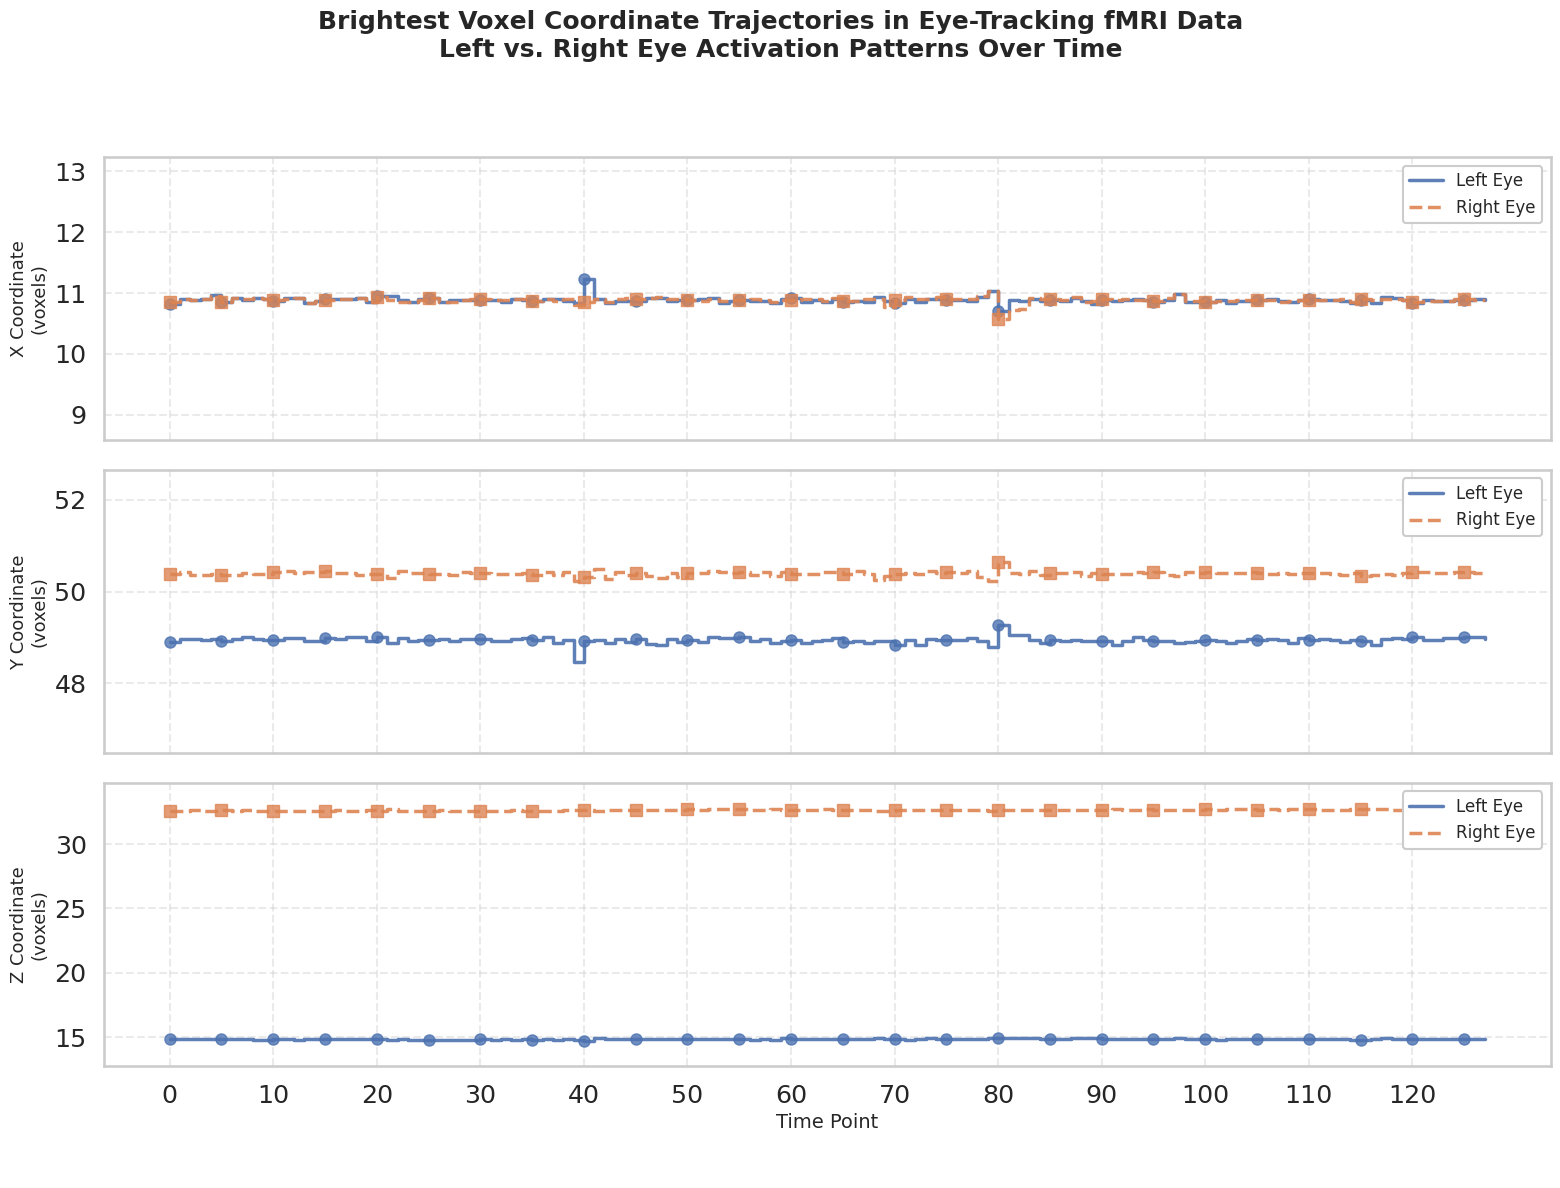

In [76]:
# Use a clean seaborn style
sns.set(style="whitegrid", context="talk", font_scale=1.1)

# Define coordinate labels and colors
coords = ['X', 'Y', 'Z']
colors = {'Left': '#4C72B0', 'Right': '#DD8452'}  # calm, modern colors
markers = {'Left': 'o', 'Right': 's'}  # different markers for better distinction
marker_interval = 5  # show markers every N time points

# Create subplots with adjusted height
fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)


for i, coord in enumerate(coords):
    # Left eye plot with markers at intervals
    left_line = axs[i].step(range(len(left_center)), left_center[:, i],
                           where='post', label='Left Eye', color=colors['Left'], 
                           linewidth=2.5, alpha=0.9)
    axs[i].plot(range(len(left_center))[::marker_interval], left_center[::marker_interval, i],
                marker=markers['Left'], color=colors['Left'], linestyle='None', 
                markersize=8, alpha=0.8)
    
    # Right eye plot with markers at intervals
    right_line = axs[i].step(range(len(right_center)), right_center[:, i],
                             where='post', label='Right Eye', color=colors['Right'], 
                             linewidth=2.5, linestyle='--', alpha=0.9)
    axs[i].plot(range(len(right_center))[::marker_interval], right_center[::marker_interval, i],
                marker=markers['Right'], color=colors['Right'], linestyle='None', 
                markersize=8, alpha=0.8)
    
    axs[i].set_ylabel(f"{coord} Coordinate\n(voxels)", fontsize=13)
    axs[i].legend(loc='upper right', fontsize=12, framealpha=1)
    axs[i].grid(True, linestyle='--', alpha=0.4)
    
    # Add a faint horizontal line at y=0 for reference
    axs[i].axhline(0, color='gray', linestyle=':', alpha=0.3)
    
    # Set y-axis to show some buffer space
    y_min = min(left_center[:, i].min(), right_center[:, i].min()) - 2
    y_max = max(left_center[:, i].max(), right_center[:, i].max()) + 2
    axs[i].set_ylim(y_min, y_max)

# X-axis shared for all subplots
axs[2].set_xlabel("Time Point", fontsize=14)
axs[2].set_xticks(np.arange(0, 121, 10))  # show ticks every 10 time points

# Add a main title with more context
fig.suptitle("Brightest Voxel Coordinate Trajectories in Eye-Tracking fMRI Data\nLeft vs. Right Eye Activation Patterns Over Time", 
             fontsize=18, weight='bold', y=0.98)

# Add explanatory text below the plot
fig.text(0.5, 0.01, 
         " ", 
         ha='center', fontsize=12, alpha=0.7)

# Make layout pretty with more space for title
plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()

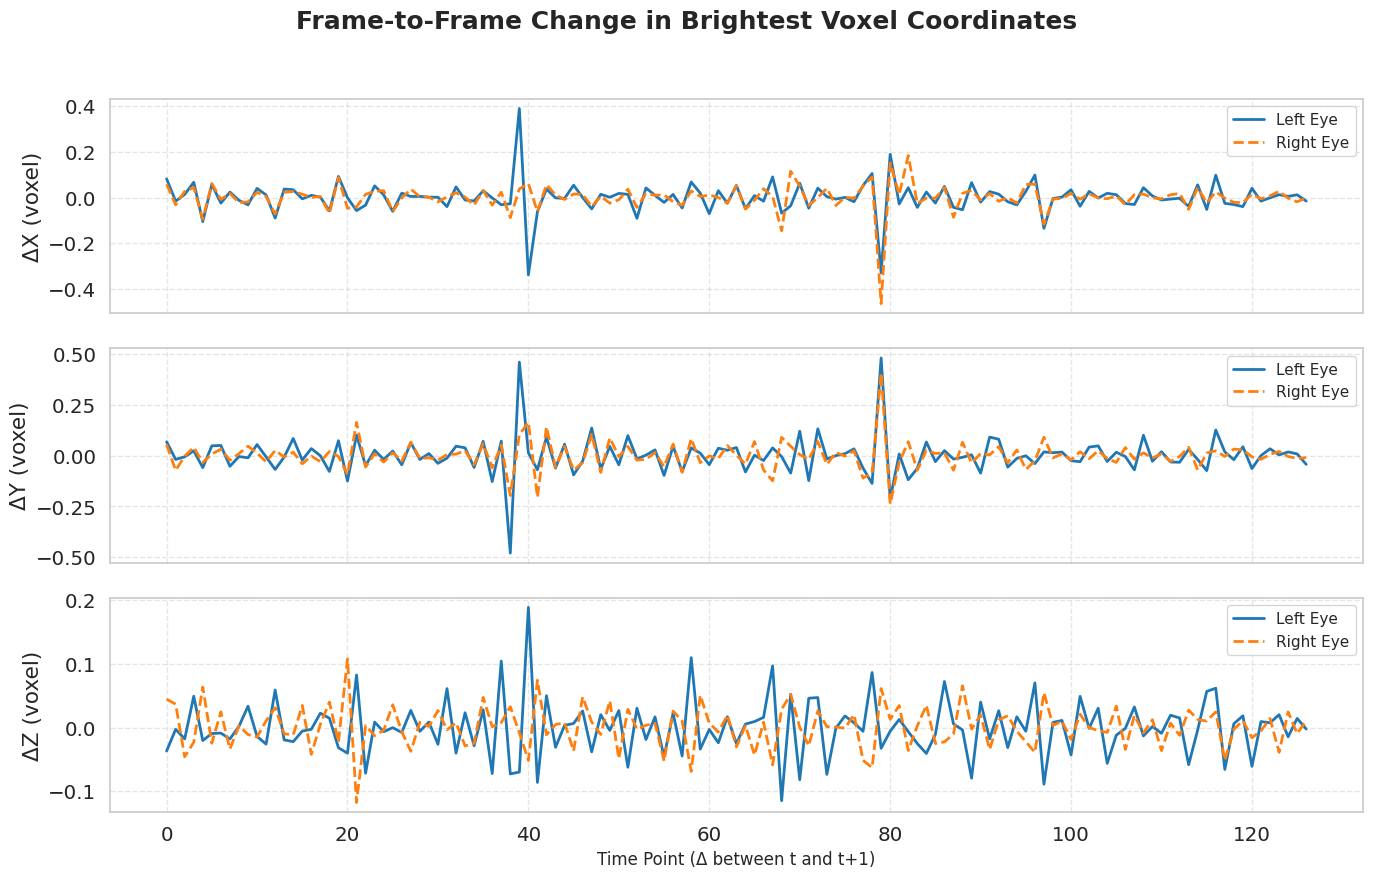

In [82]:
# Optional: set your own color palette
sns.set(style="whitegrid", context="notebook", font_scale=1.3)

# Axis labels
coords = ['X', 'Y', 'Z']
colors = {'Left': '#1f77b4', 'Right': '#ff7f0e'}
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

for i, coord in enumerate(coords):
    axs[i].plot(left_deltas[:, i], label='Left Eye', color=colors['Left'], linewidth=2)
    axs[i].plot(right_deltas[:, i], label='Right Eye', color=colors['Right'], linewidth=2, linestyle='--')
    axs[i].set_ylabel(f'Δ{coord} (voxel)')
    axs[i].legend(loc='upper right', fontsize=11)
    axs[i].grid(True, linestyle='--', alpha=0.5)

axs[2].set_xlabel('Time Point (Δ between t and t+1)', fontsize=12)
fig.suptitle("Frame-to-Frame Change in Brightest Voxel Coordinates", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig.savefig("ChangeBetweenVoxels.png", dpi=300)

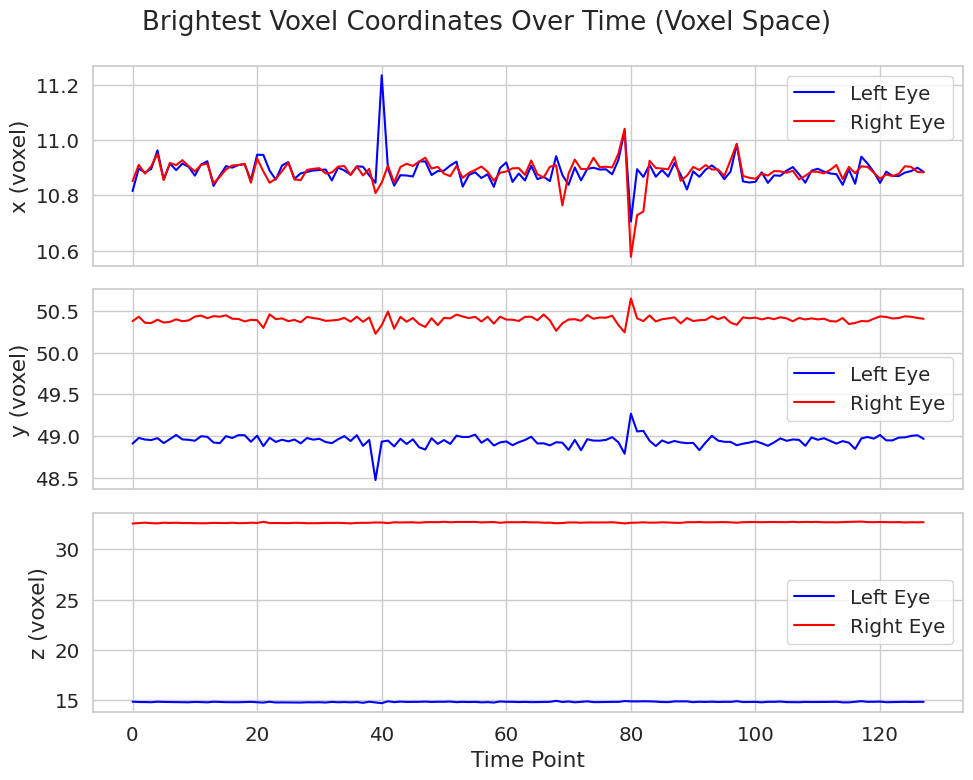

In [83]:
# Plot each axis over time
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

coords = ['x', 'y', 'z']
for i in range(3):
    axs[i].plot(left_center[:, i], label='Left Eye', color='blue')
    axs[i].plot(right_center[:, i], label='Right Eye', color='red')
    axs[i].set_ylabel(f'{coords[i]} (voxel)')
    axs[i].legend()
    axs[i].grid(True)

axs[2].set_xlabel('Time Point')
plt.suptitle("Brightest Voxel Coordinates Over Time (Voxel Space)")
plt.tight_layout()
plt.show()+

fig.savefig("ChangeBetweenCoordinates.png", dpi=300)

In [31]:
# # Create a DataFrame with labeled columns - CSV file
# df_centers = pd.DataFrame({
#     'timepoint': np.arange(len(left_center)),
#     'x_left': left_center[:, 0],
#     'y_left': left_center[:, 1],
#     'z_left': left_center[:, 2],
#     'x_right': right_center[:, 0],
#     'y_right': right_center[:, 1],
#     'z_right': right_center[:, 2],
# })

# # Save to CSV
# df_centers.to_csv("eye_centers_over_time.csv", index=False)

# print("Saved to eye_centers_over_time.csv")

Saved to eye_centers_over_time.csv


/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



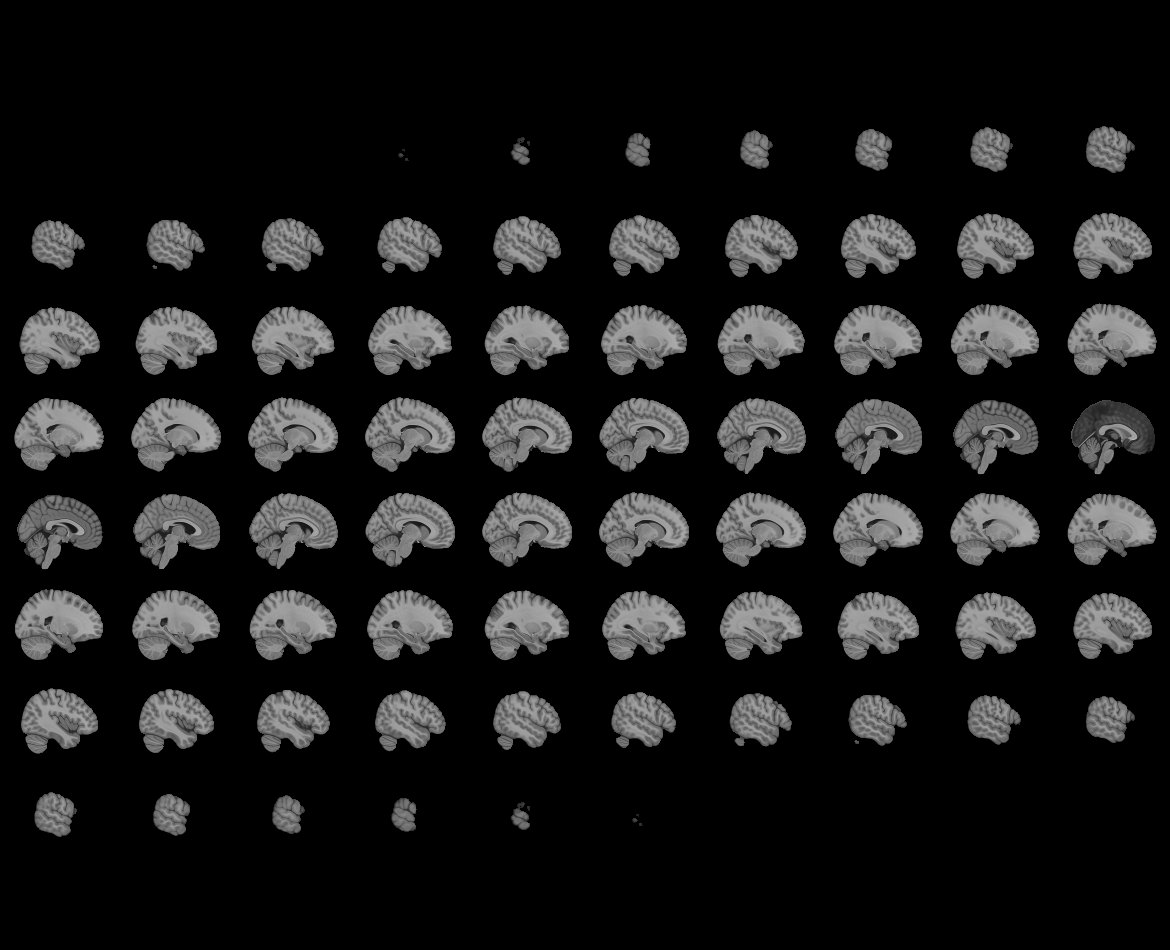
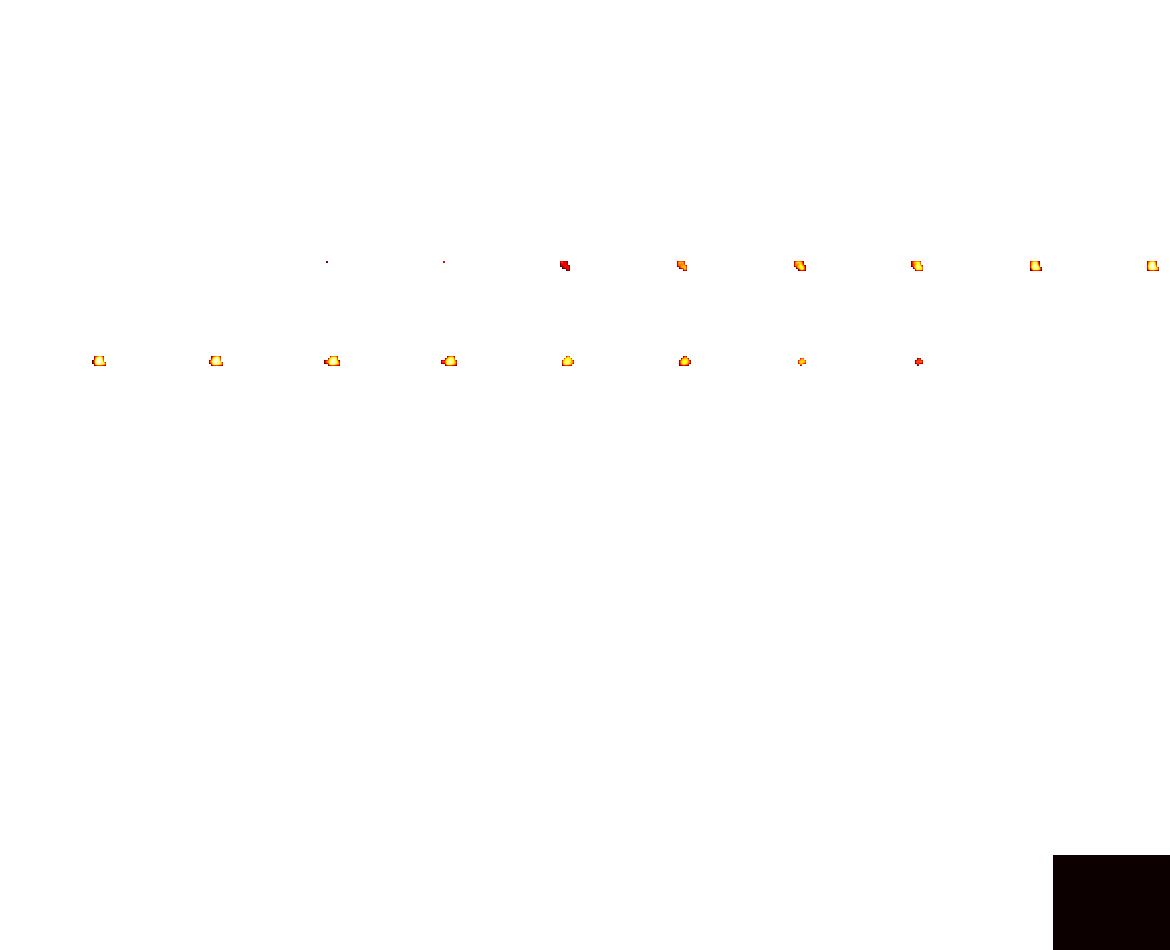

In [22]:
plotting.view_img(left_eye_time[45], threshold=0)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



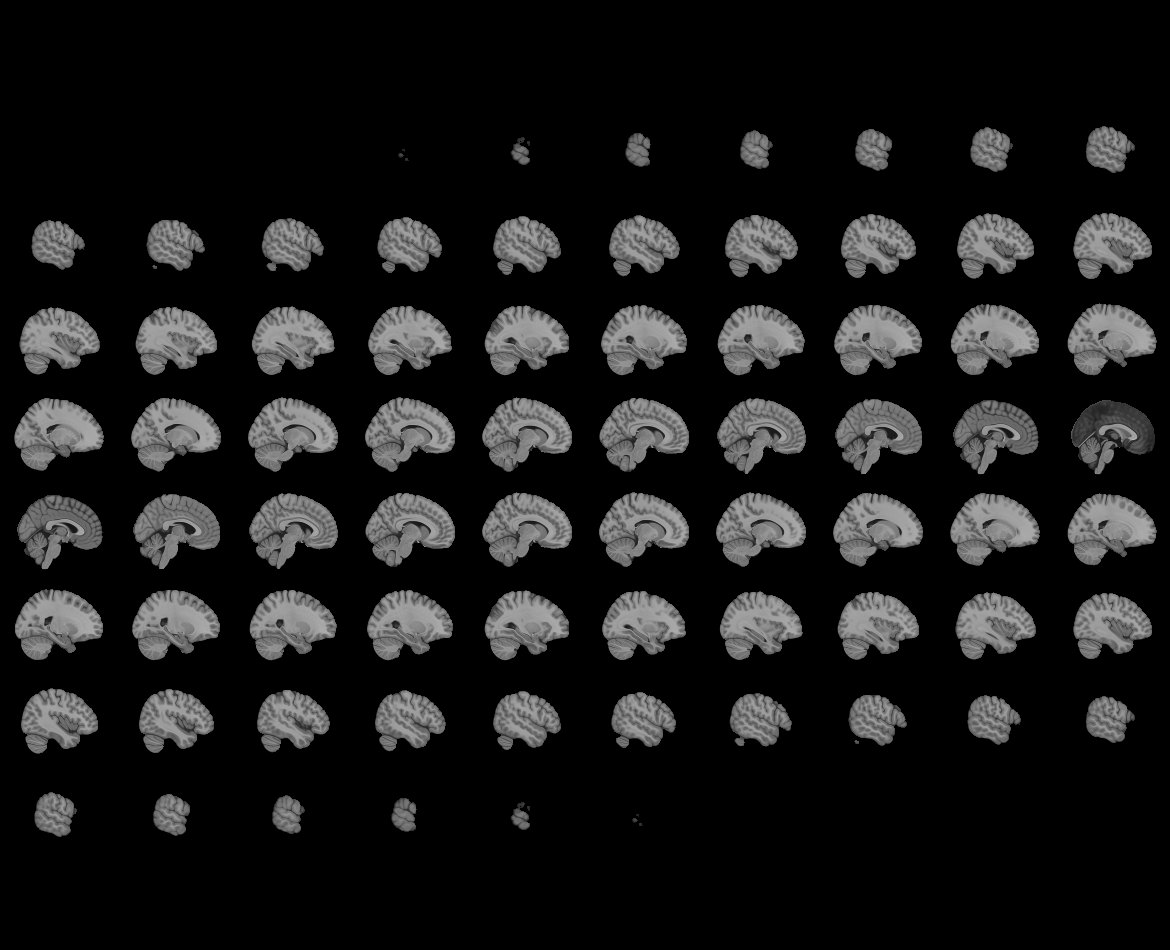
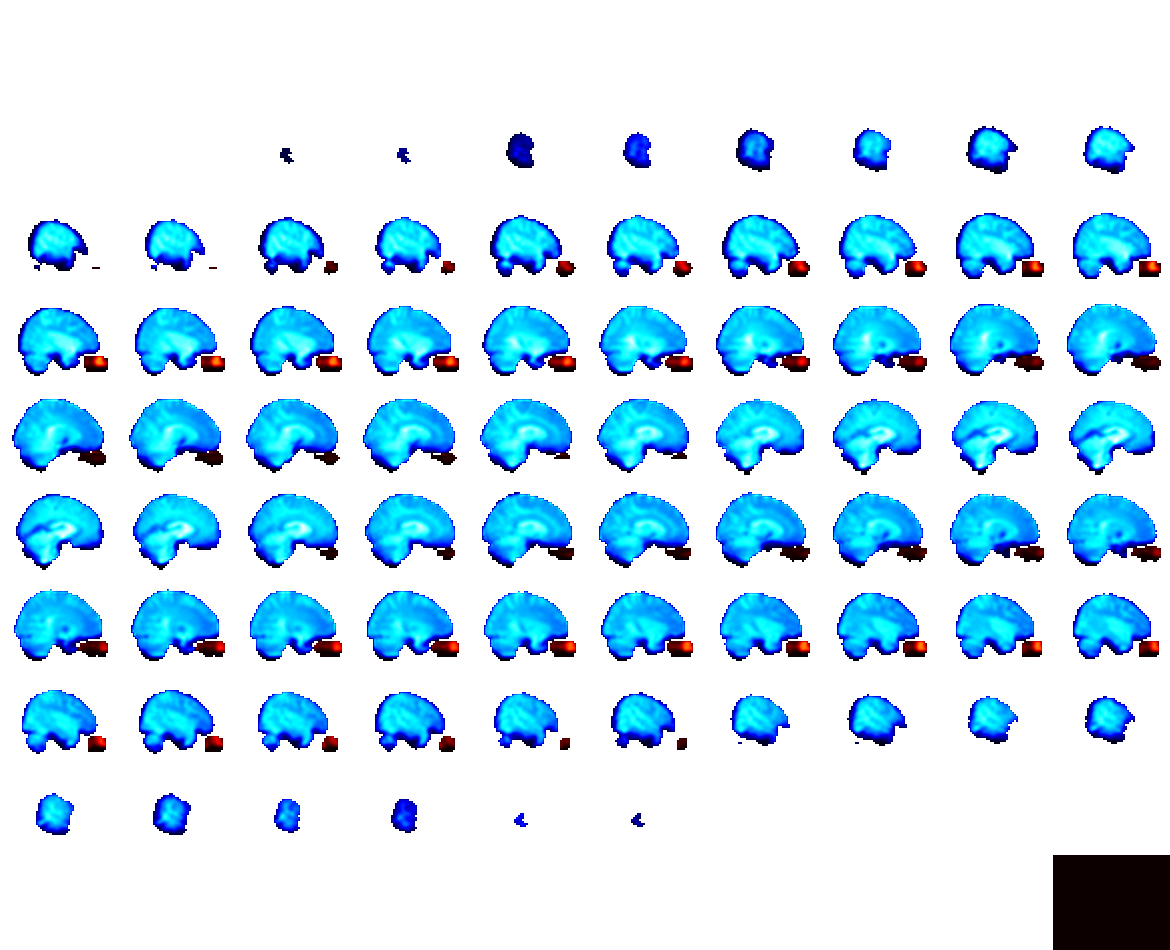

In [64]:
# brain without eyes

without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)
plotting.view_img(without_gm_img)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



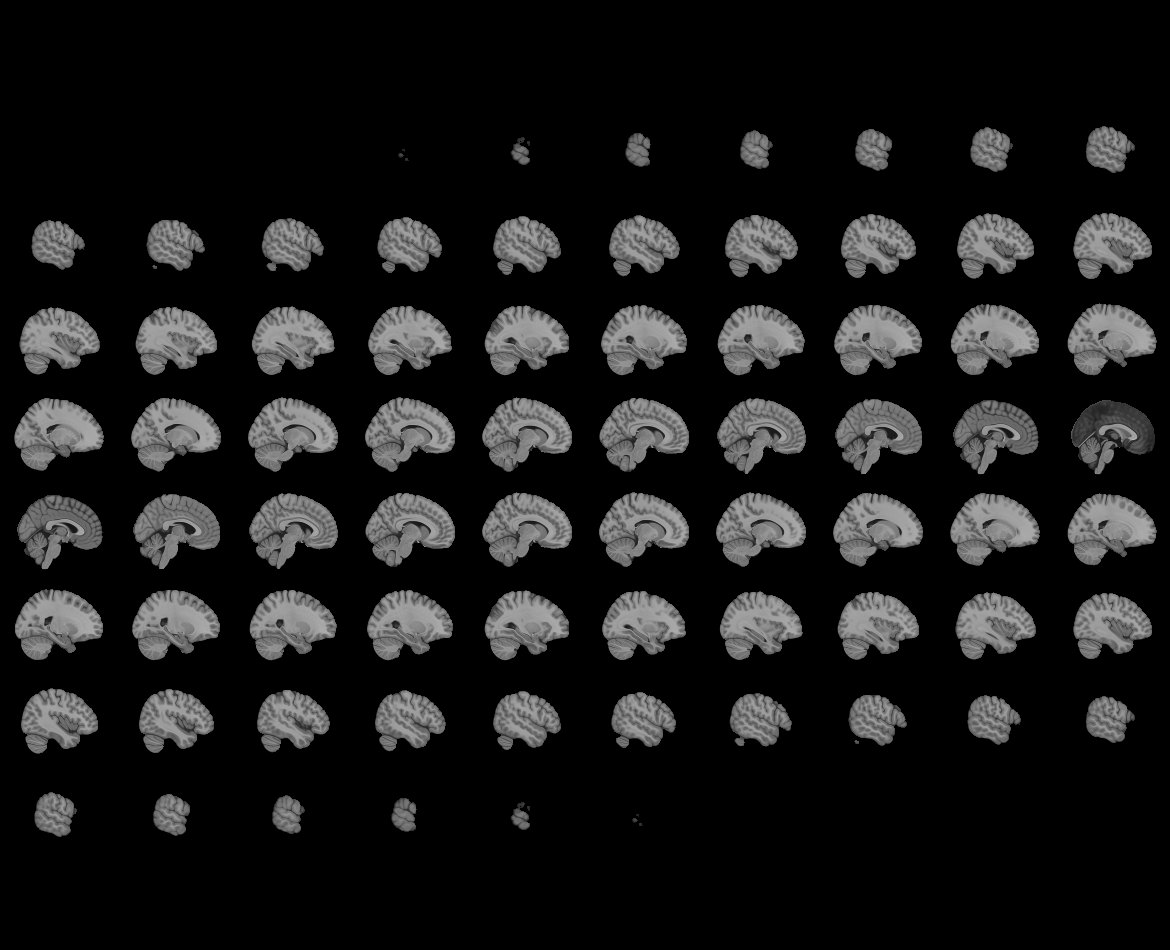
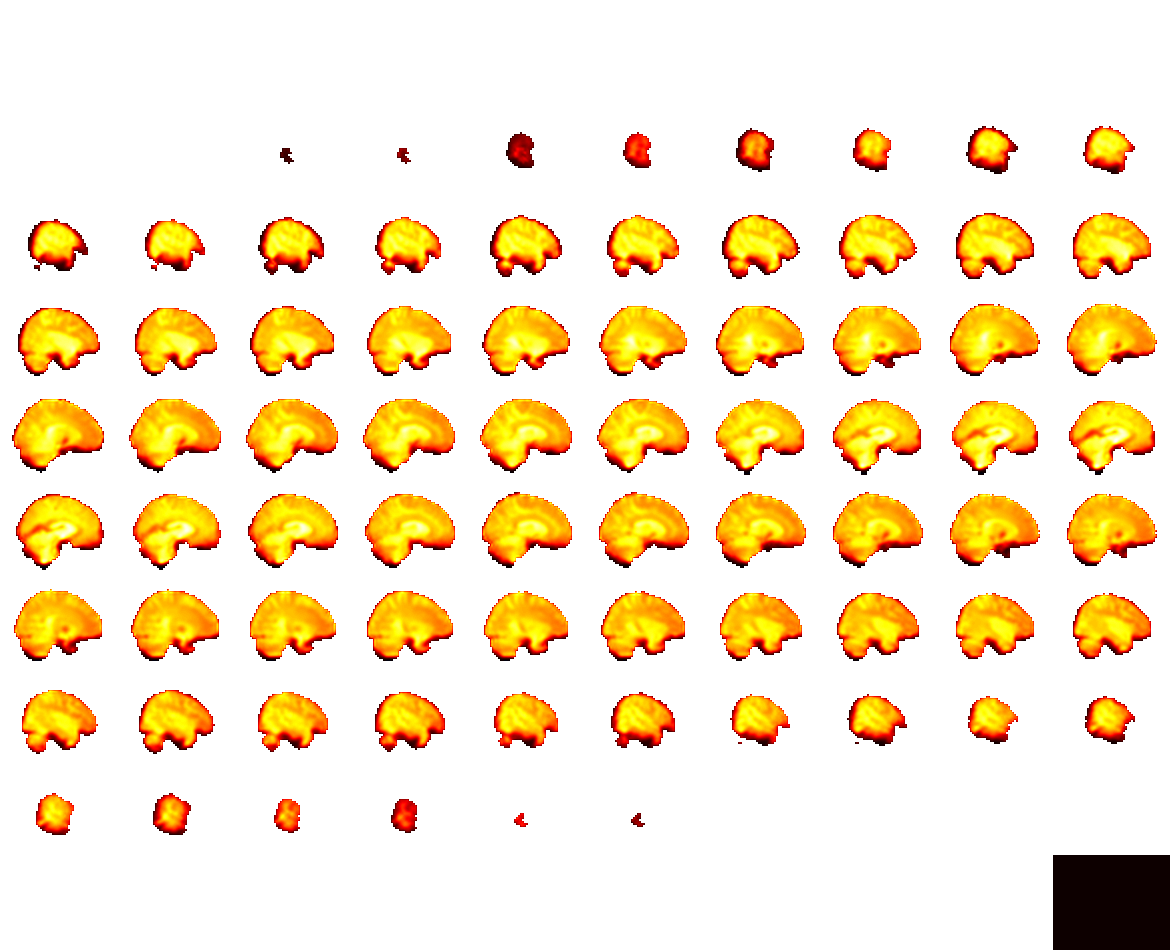

In [44]:
# brain without eyes

brain_only_img = nib.Nifti1Image(brawithout_gmin_only, affine=fmri_img.affine)
plotting.view_img(brain_only_img)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



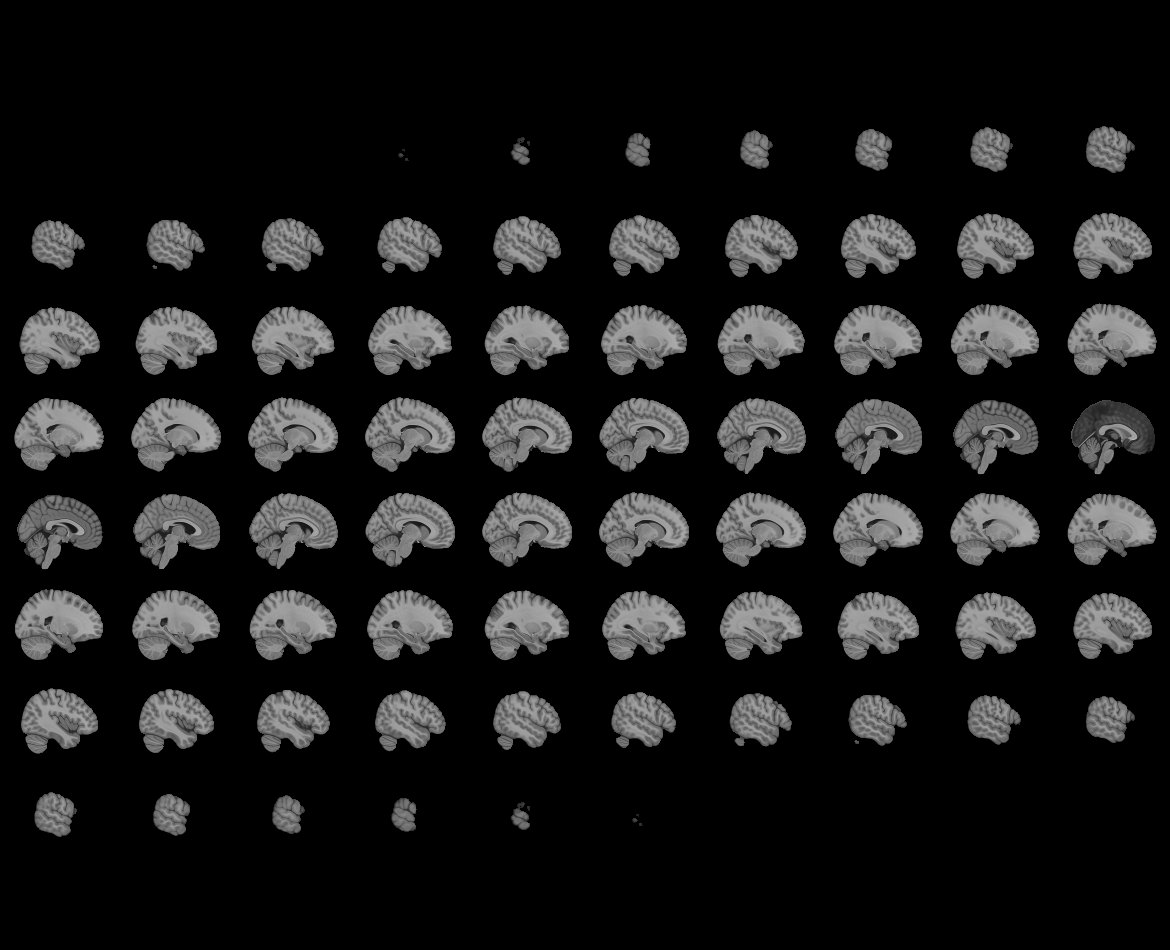
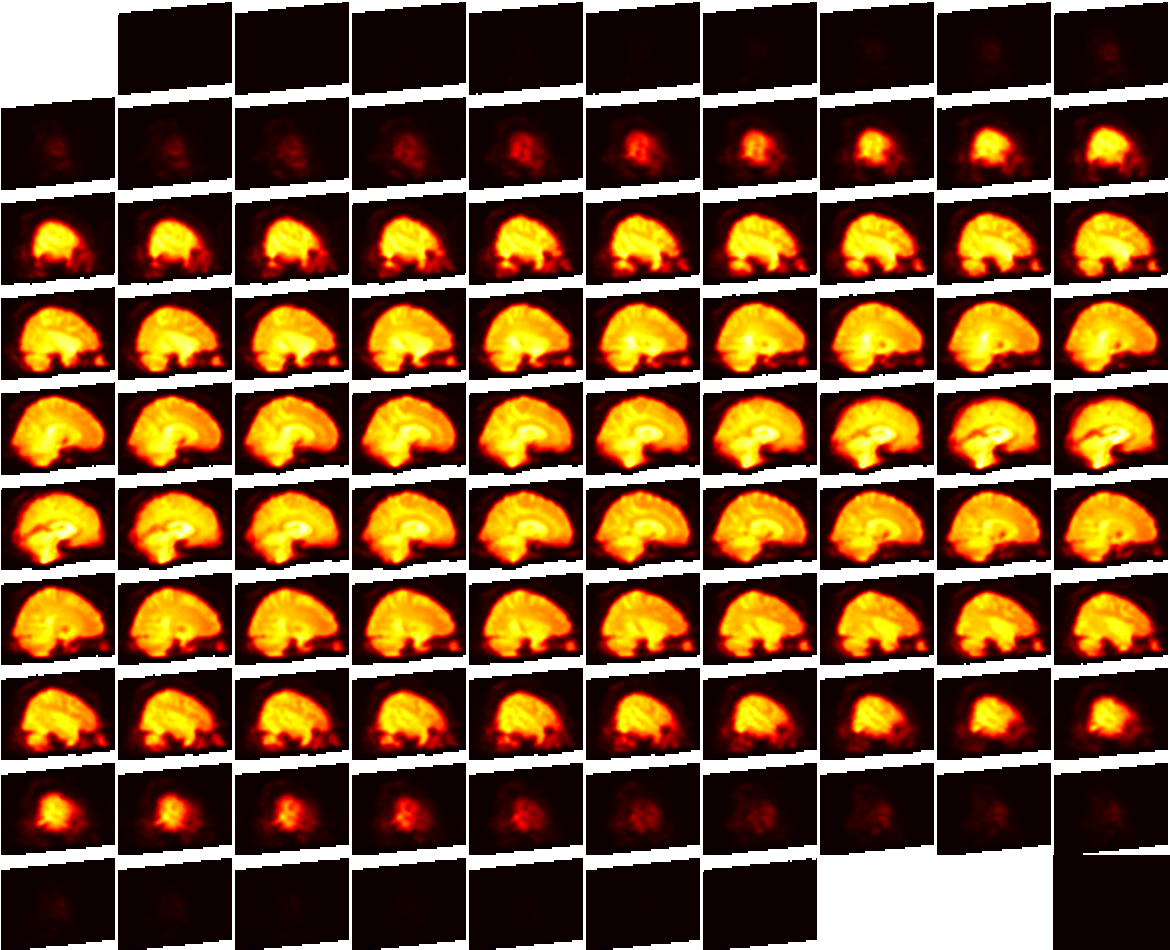

In [45]:
# brain with eyes

fmri_volume_img = nib.Nifti1Image(fmri_volume, affine=fmri_img.affine)
plotting.view_img(fmri_volume_img)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



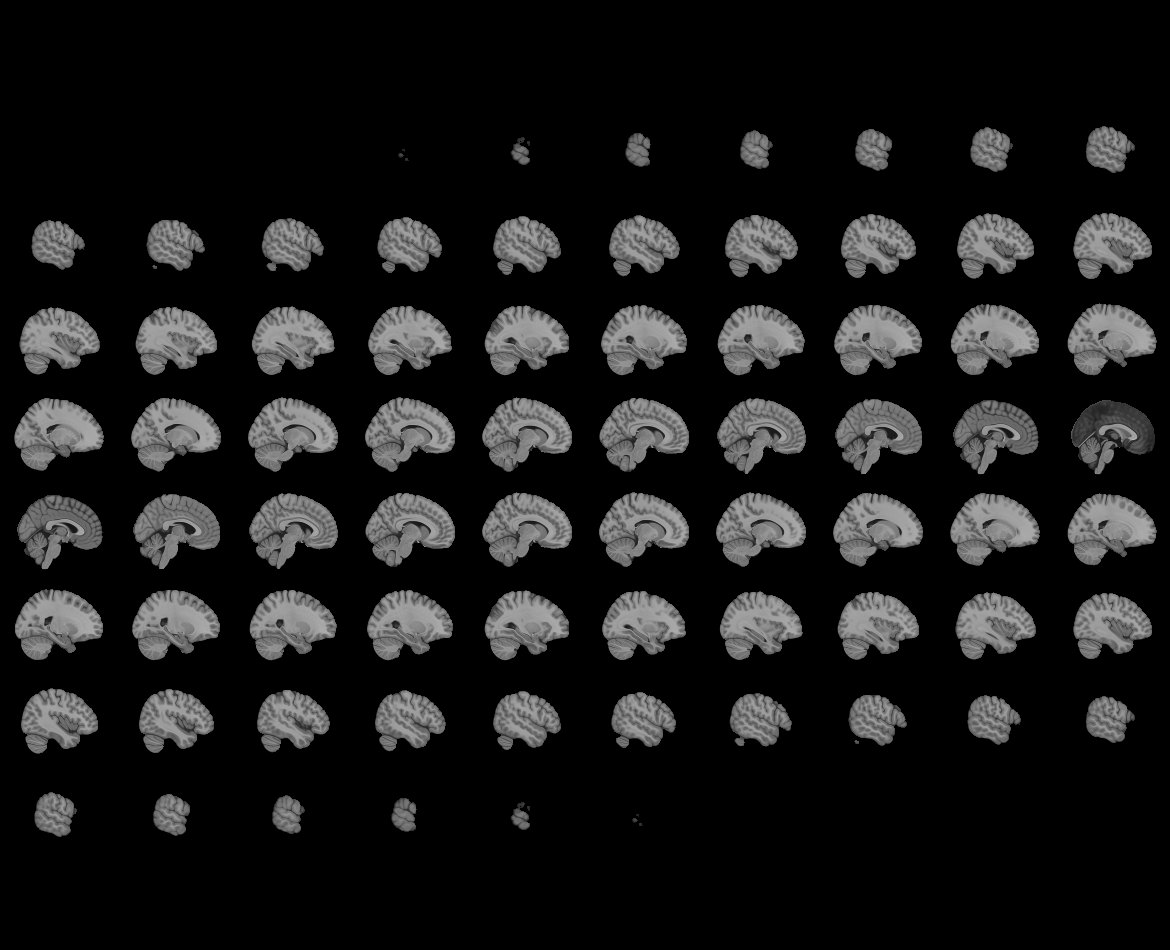
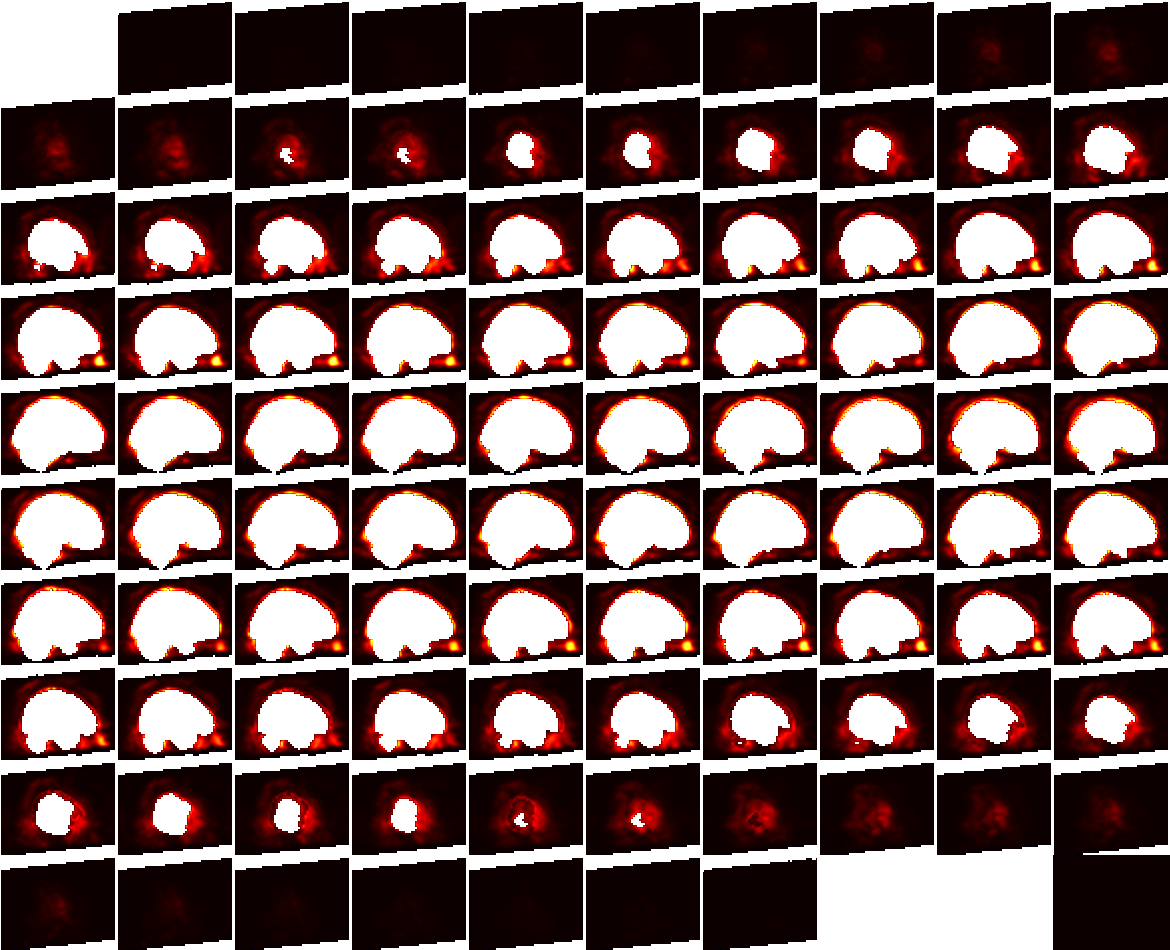

In [46]:
eyes_img = nib.Nifti1Image(eyes, affine=fmri_img.affine)
plotting.view_img(eyes_img)

Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 15%)


/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



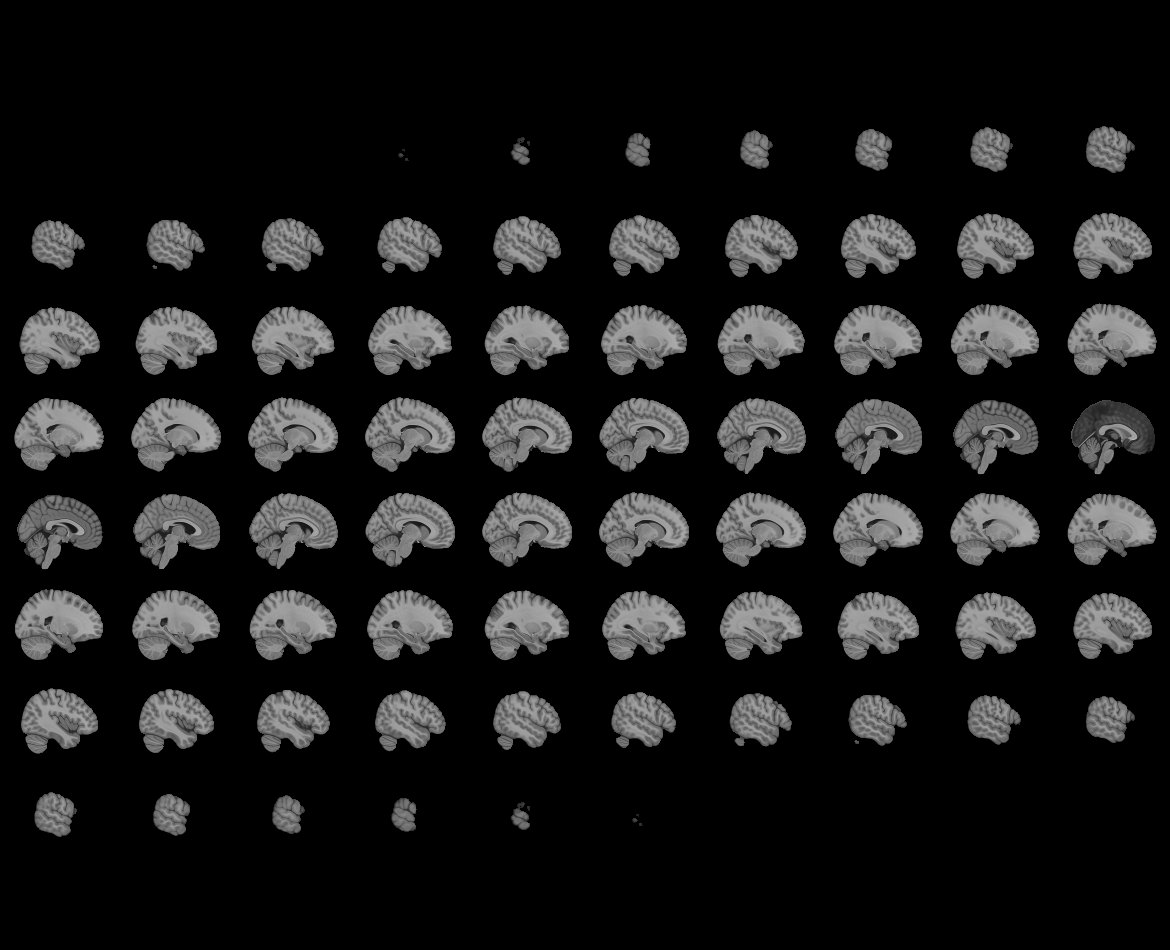
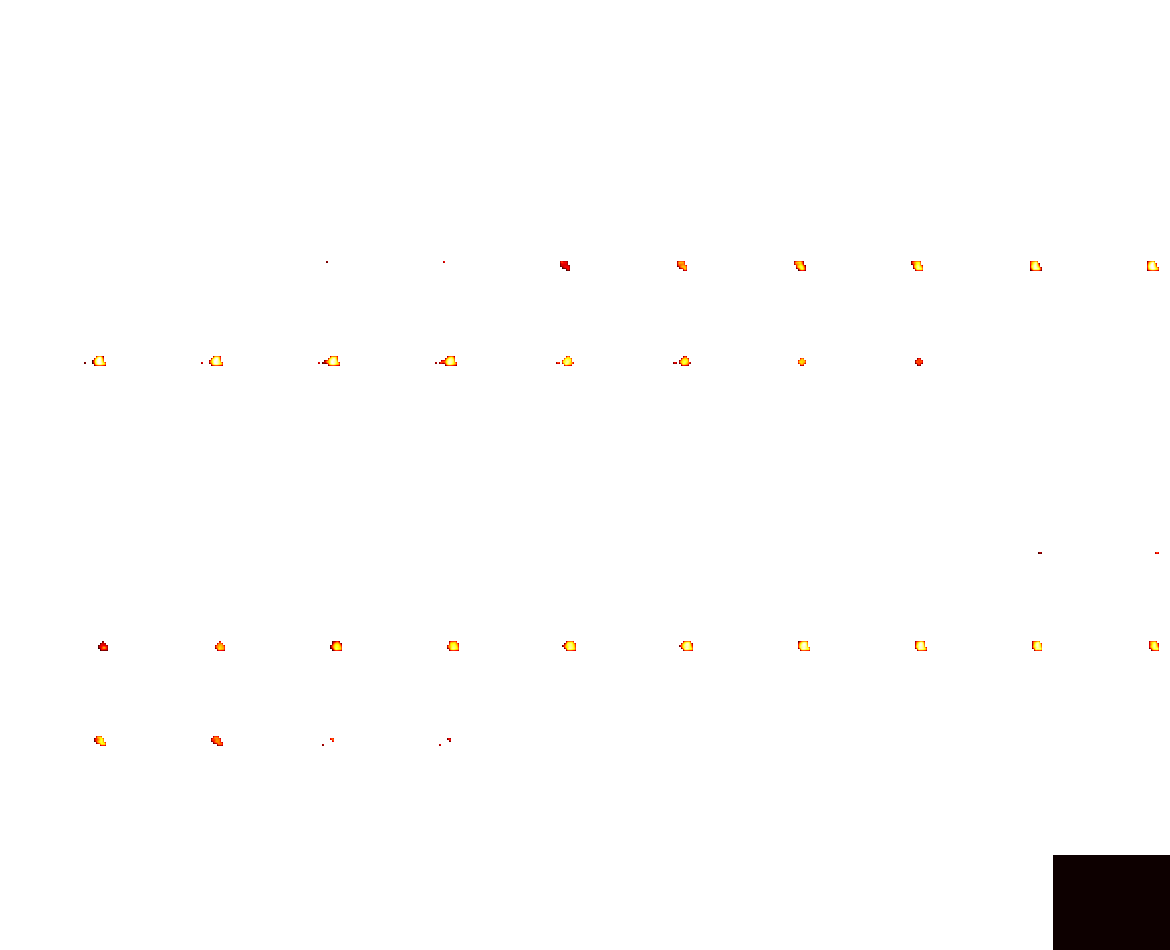

In [76]:
# # Define Y-axis bounds
# y_start = 100
# z_start = -70
# y_end = y_start - 59  # So y = 100 down to y = 40 (smaller values)
# z_end = z_start + 37

# # Mask the region of interest
# eyes_roi = np.zeros_like(eyes)
eyes_roi = without_gm
# #eyes_roi[:, y_end:y_start, :] = eyes[:, y_end:y_start, :]
# eyes_roi[:, y_end:y_start, z_start:z_end] = eyes[:, y_end:y_start, z_start:z_end]

# Flatten the ROI and keep only non-zero values
flat_eyes_roi = eyes_roi.ravel()
nonzero_indices = np.flatnonzero(flat_eyes_roi)
n_nonzero = len(nonzero_indices)
top_n = int(n_nonzero * 0.01)

print(f"Total non-zero voxels in ROI: {n_nonzero}")
print(f"Extracting top {top_n} voxels (top 15%)")

# Get top 100 brightest voxel indices within the ROI
flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T

#flat_indices = np.argpartition(eyes_roi.ravel(), -300)[-300:]
#sorted_flat_indices = flat_indices[np.argsort(eyes_roi.ravel()[flat_indices])[::-1]]
#brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T

# Create empty image to store the brightest voxels
brightest_voxels_img = np.zeros_like(eyes)

# Set the intensity values at those coordinates
for x, y, z in brightest_coords:
    brightest_voxels_img[x, y, z] = eyes[x, y, z]  # You can also use eyes_roi here; same in that range

# Wrap into Nifti1Image using original affine
brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")

# Plot interactively
plotting.view_img(brightest_voxels_nii, threshold=0) # opacity=0.5

# largest and the second largest components

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



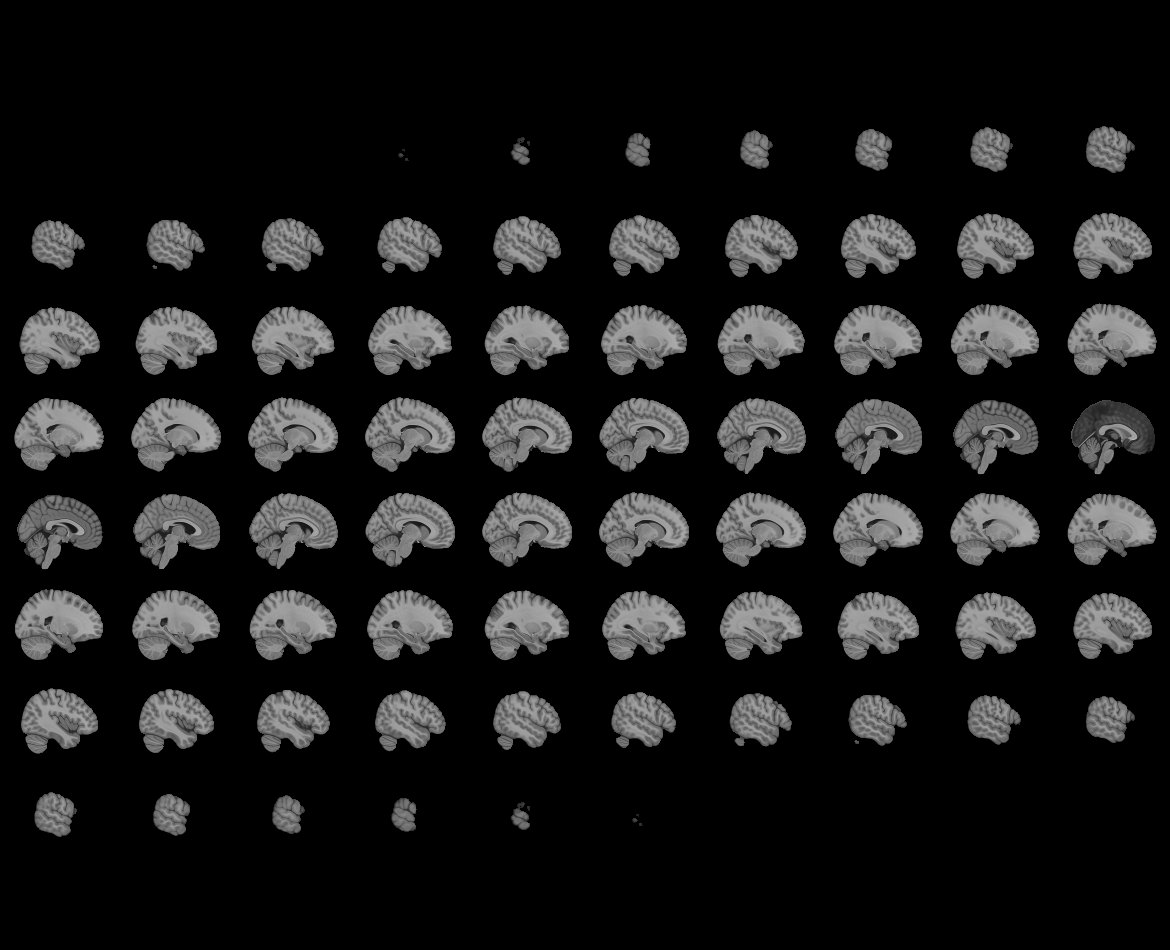
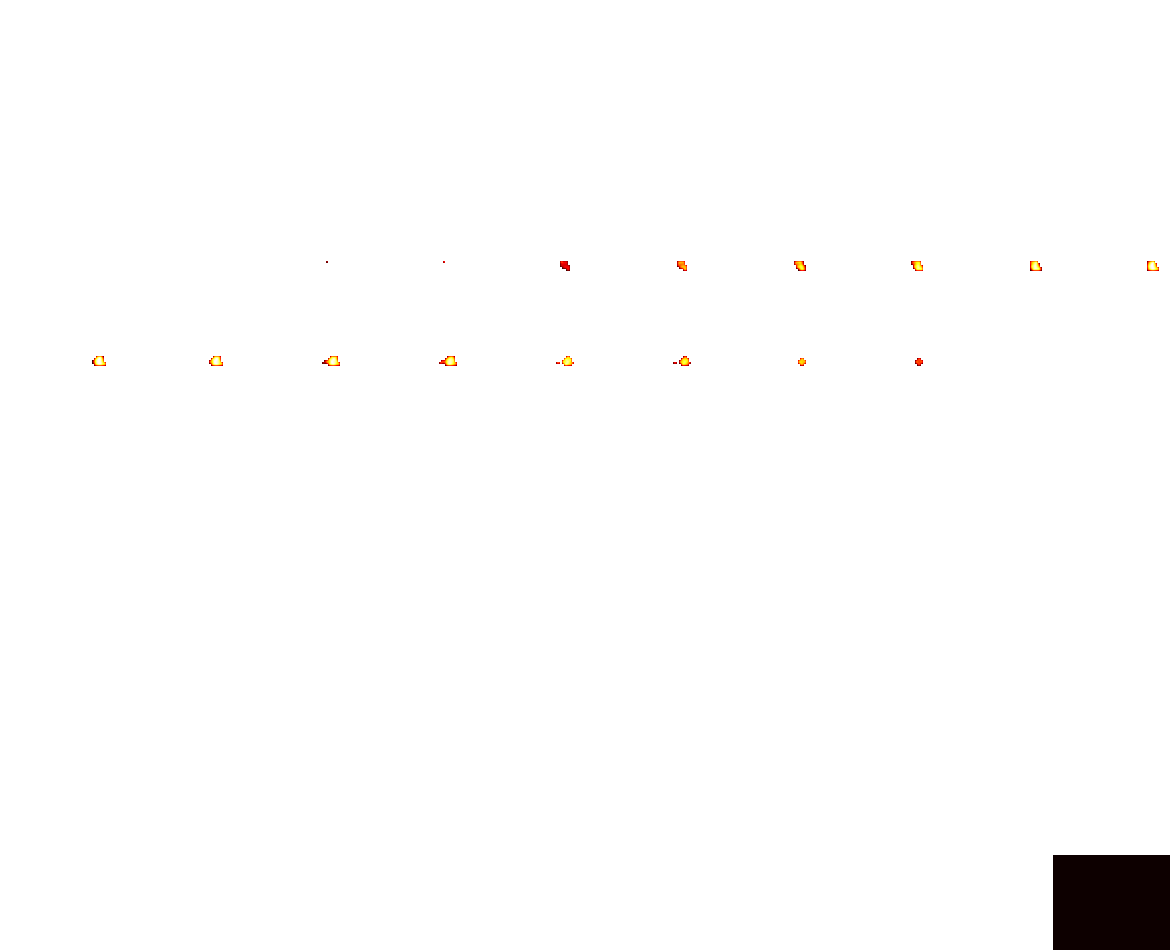

In [79]:
# Label connected components (regions of adjacent bright voxels)
labeled, num_labels = label(brightest_voxels_img)

# Find the size of each connected component (cluster)
component_sizes = np.bincount(labeled.ravel())

# Ignore background (label 0), sort the components by size and find the largest and second largest components
sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)

# Ignore background (label 0) and find the largest component
largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
largest_component = labeled == largest_component_label

second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
# Create an image of the largest component
largest_component_img = np.zeros_like(fmri_volume)
largest_component_img[largest_component] = fmri_volume[largest_component]

# Create the second largest component (second biggest cluster)
second_largest_component = labeled == second_largest_label

# Create an image of the second largest component
second_largest_img = np.zeros_like(fmri_volume)
second_largest_img[second_largest_component] = fmri_volume[second_largest_component]

# Wrap into a NIfTI image
second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)

# Wrap into a NIfTI image
largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)

# Create an image for both clusters combined (sum of both masks)
combined_clusters_img = np.zeros_like(fmri_volume)
combined_clusters_img[largest_component] = fmri_volume[largest_component]
combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]

# Wrap into a NIfTI image
combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)

# Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
largest_coords = np.column_stack(np.where(largest_component))
second_largest_coords = np.column_stack(np.where(second_largest_component))

largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]

if largest_coords_world[0][0] < 0:
    left_eye_img = largest_component_nii
    right_eye_img = second_largest_nii
else:
    left_eye_img = second_largest_nii
    right_eye_img = largest_component_nii

# Save the combined clusters result
nib.save(combined_clusters_nii, "combined_clusters_brightest_voxels.nii.gz")

# Save the largest component
nib.save(left_eye_img, "left_eye_both_masks.nii.gz")

# Save the second largest component
nib.save(right_eye_img, "right_eye_both_masks.nii.gz")

# Plot interactively both clusters together (overlaying)
plotting.view_img(left_eye_img, threshold=0)

# Save the result


# Plot interactively
# plotting.view_img(second_largest_nii, threshold=0)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



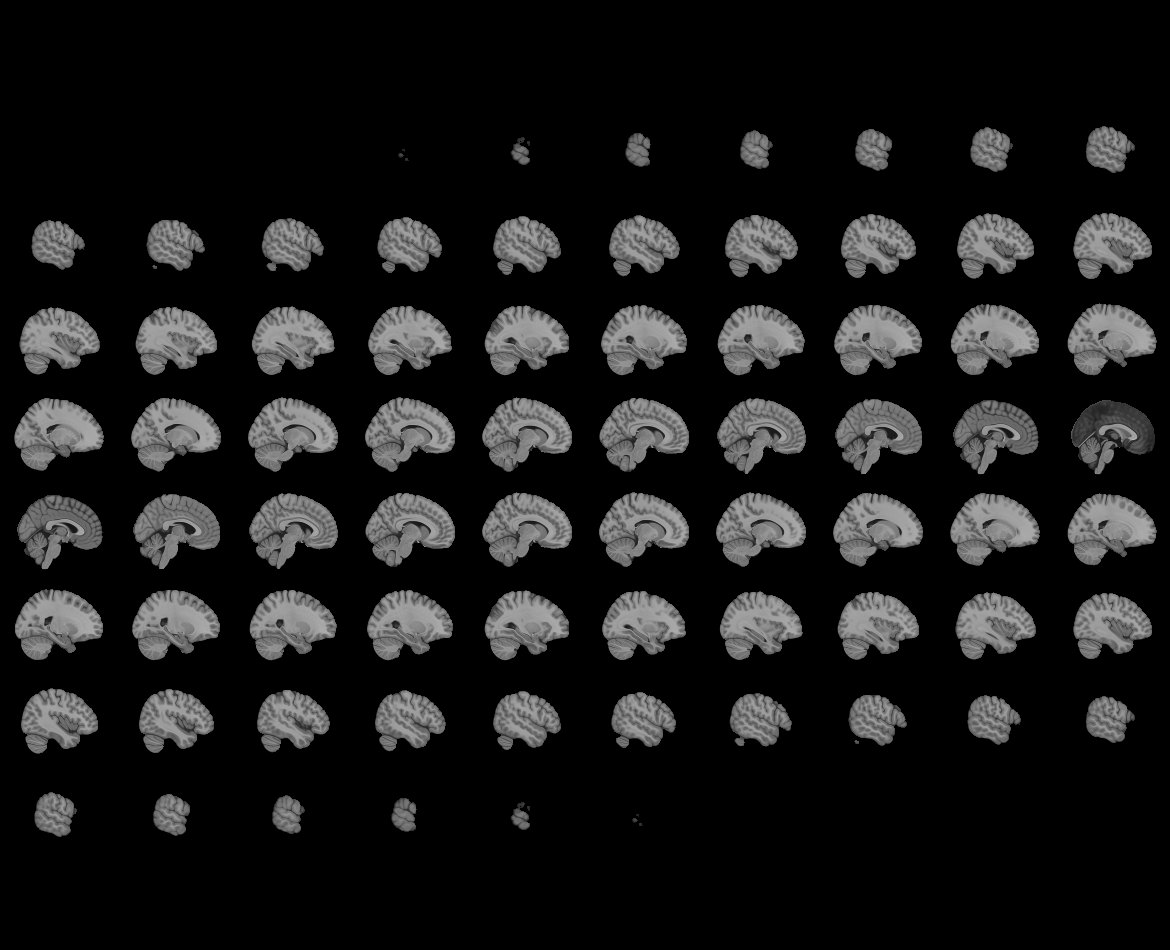
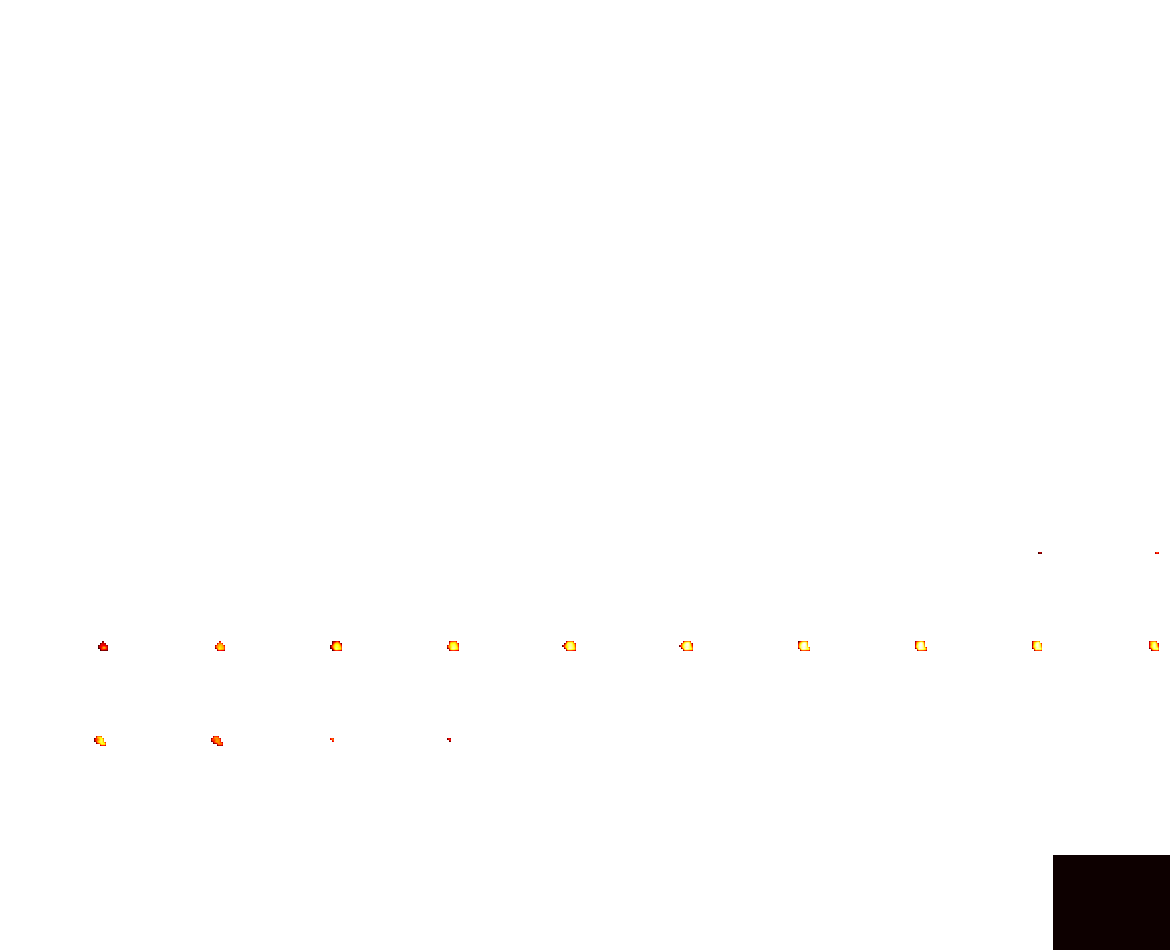

In [80]:
# Plot interactively both clusters together (overlaying)
plotting.view_img(right_eye_img, threshold=0)